# Preprocessing

In [1]:
import os
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import loguniform
import json
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc, f1_score, recall_score

In [2]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns


Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [3]:
df_copied = df.copy()

### Train test split

In [4]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School','County','num_lte_5ppb'])
y = df_copied['target_col']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)

We now further split the train and test set.

In [5]:
X_train_t, X_train_v, y_train_t, y_train_v = train_test_split(X_train, y_train, test_size=0.2, random_state=40, stratify=y_train)

In [6]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

### Pipeline

In [7]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

## Baseline model : Logistic regression without penalty 

In [8]:
clf = Pipeline([ ('preprocessor', preprocessor), ('classifier', LogisticRegression(penalty=None, max_iter=1000))  ])

clf.fit(X_train_t, y_train_t)

y_pred = clf.predict(X_train_v)
print(classification_report(y_train_v, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.87      0.78       254
           1       0.79      0.59      0.67       215

    accuracy                           0.74       469
   macro avg       0.75      0.73      0.73       469
weighted avg       0.75      0.74      0.73       469



In [9]:
model_accuracy = accuracy_score(y_train_v,y_pred)
model_accuracy

0.7398720682302772

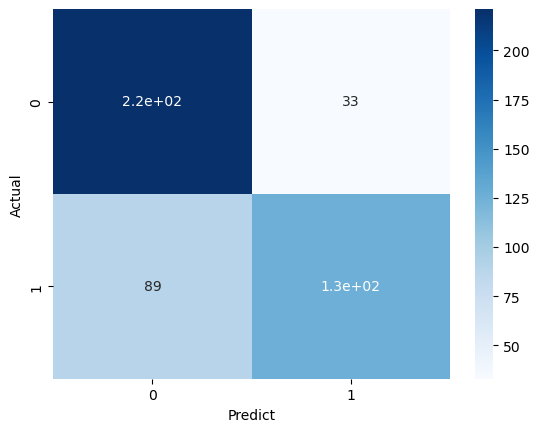

In [10]:
cm = confusion_matrix(y_train_v,y_pred)
sns.heatmap(cm,annot=True, cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

## Hyperparameter testing

In [11]:
n_samples = X.shape[0]

n_classes = len(np.unique(y))

preprocessor.fit(X)
X_transformed = preprocessor.transform(X)
n_features = X_transformed.shape[1]

print(f"Samples: {n_samples}")
print(f"Features after encoding: {n_features}")
print(f"Classes: {n_classes}")
print(f"Features * Classes: {n_features * n_classes}")




Samples: 2929
Features after encoding: 809
Classes: 2
Features * Classes: 1618


In [12]:
rng = np.random.default_rng(seed=40)

Fold 1 : Best params: {'classifier__C': np.float64(1.5899642107526444), 'classifier__l1_ratio': 0.3, 'classifier__penalty': 'elasticnet'} : F1: 0.6824 : Recall: 0.6075 : Accuracy: 0.7420 : ROC-AUC: 0.7479
Fold 2 : Best params: {'classifier__C': np.float64(2.402056248835655), 'classifier__penalty': 'l2'} : F1: 0.6791 : Recall: 0.5907 : Accuracy: 0.7441 : ROC-AUC: 0.7343
Fold 3 : Best params: {'classifier__C': np.float64(4.703504364003687), 'classifier__penalty': 'l2'} : F1: 0.6736 : Recall: 0.6000 : Accuracy: 0.7335 : ROC-AUC: 0.7594
Fold 4 : Best params: {'classifier__C': np.float64(1.2388901115877902), 'classifier__penalty': 'l2'} : F1: 0.7028 : Recall: 0.6355 : Accuracy: 0.7543 : ROC-AUC: 0.7951
Fold 5 : Best params: {'classifier__C': np.float64(2.402056248835655), 'classifier__penalty': 'l2'} : F1: 0.6849 : Recall: 0.5841 : Accuracy: 0.7543 : ROC-AUC: 0.7739

Mean performance across outer folds:
f1: 0.6846 ± 0.0099
recall: 0.6036 ± 0.0178
accuracy: 0.7456 ± 0.0079
roc_auc: 0.7621 ± 

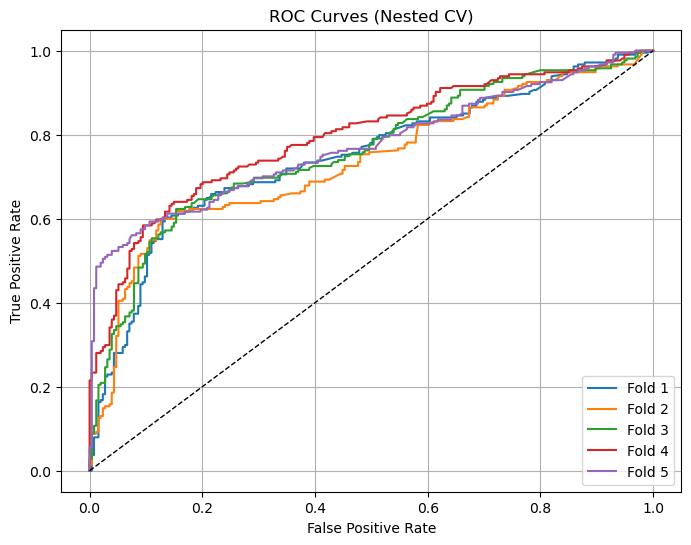

In [13]:

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, solver='saga'))
])


param_grid = [
    {'classifier__penalty': ['l1'], 'classifier__C': loguniform(0.01,10)},
    {'classifier__penalty': ['l2'], 'classifier__C': loguniform(0.01,10)},
    {'classifier__penalty': ['elasticnet'], 'classifier__C': loguniform(0.01,10), 'classifier__l1_ratio': [0.3,0.5, 0.7, 0.9]},
]


outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

metrics = {'f1': f1_score, 'recall': recall_score, 'accuracy': accuracy_score, 'roc_auc': roc_auc_score}

# Storing results
outer_results = {metric: [] for metric in metrics}
roc_curves = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Inner CV: hyperparameter tuning
    random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=inner_cv, scoring='roc_auc', random_state=40, n_jobs=-1)
    random_search.fit(X_tr, y_tr)
    best_model = random_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_te)
    y_proba = best_model.predict_proba(X_te)[:, 1]
    
    # Metrics
    for metric_name, func in metrics.items():
        if metric_name == 'roc_auc':
            outer_results[metric_name].append(func(y_te, y_proba))
        else:
            outer_results[metric_name].append(func(y_te, y_pred))
    
   
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_curves.append((fpr, tpr))
    
    print(f"Fold {fold} : Best params: {random_search.best_params_} : F1: {outer_results['f1'][-1]:.4f} : Recall: {outer_results['recall'][-1]:.4f} : Accuracy: {outer_results['accuracy'][-1]:.4f} : ROC-AUC: {outer_results['roc_auc'][-1]:.4f}")


print("\nMean performance across outer folds:")
for metric_name, scores in outer_results.items():
    print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ROC curves for all folds
plt.figure(figsize=(8,6))
for i, (fpr, tpr) in enumerate(roc_curves, 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Nested CV)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
